# Trotter simulation of a 10-plaqutte system

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
try:
    import jax.numpy as jnp
    from jax.scipy.linalg import expm
except ImportError:
    jnp = np
    from scipy.linalg import expm
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, Batch
from heavyhex_qft.triangular_z2 import TriangularZ2Lattice
from heavyhex_qft.utils import subspace_projection

use_simulator = False

In [2]:
lattice = TriangularZ2Lattice('''
 * * *
* * * *
 * * *
''')

# lattice = TriangularZ2Lattice('''
#  * * * *
#   * * *
#  * * * *
#     * *
#  * * * *
# * * * *
#  * * * *
# ''')

## Start with an initial state with a single link excitation and evolve for 10 steps

In [3]:
K = 0.5
delta_t = 0.1

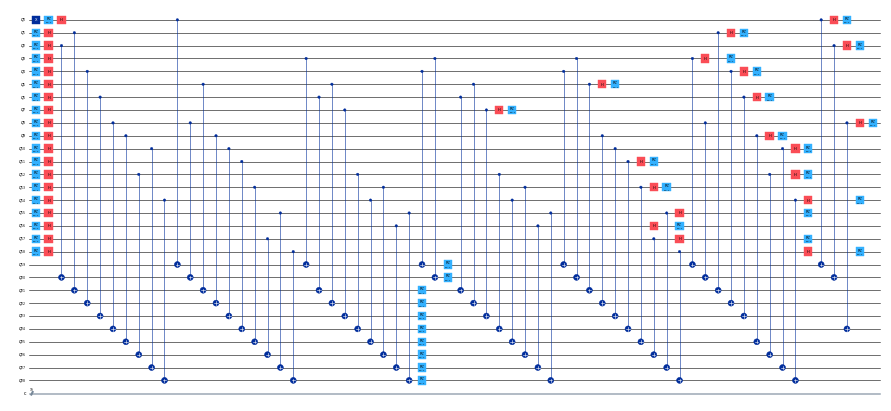

In [4]:
snapshots_cx = []

circuit = QuantumCircuit(lattice.num_links + lattice.num_plaquettes, lattice.num_links)
circuit.x(0)
for _ in range(10):
    circuit.compose(lattice.electric_evolution(0.5 * delta_t), inplace=True)
    circuit.compose(lattice.magnetic_evolution(K, delta_t), inplace=True)
    circuit.compose(lattice.electric_evolution(0.5 * delta_t), inplace=True)
    snapshots_cx.append(circuit.copy())

snapshots_cx[0].draw('mpl', scale=0.2, fold=100)

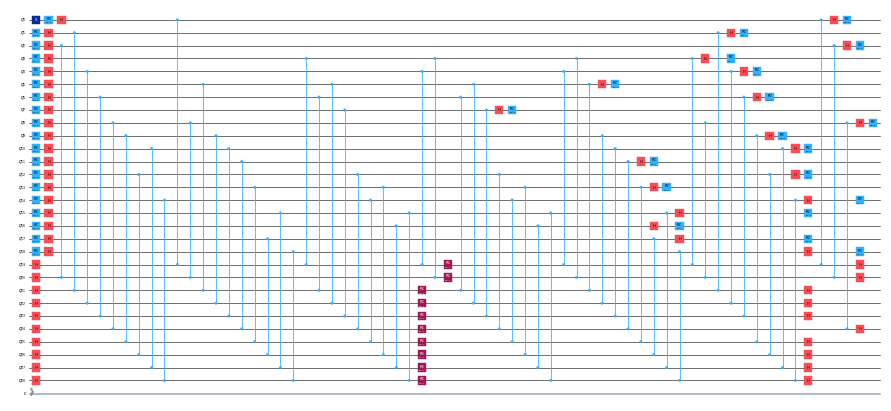

In [5]:
snapshots_cz = []

circuit = QuantumCircuit(lattice.num_links + lattice.num_plaquettes, lattice.num_links)
circuit.x(0)
for _ in range(10):
    circuit.compose(lattice.electric_evolution(0.5 * delta_t), inplace=True)
    circuit.compose(lattice.magnetic_evolution(K, delta_t, basis_2q='cz'), inplace=True)
    circuit.compose(lattice.electric_evolution(0.5 * delta_t), inplace=True)
    snapshots_cz.append(circuit.copy())

snapshots_cz[0].draw('mpl', scale=0.2, fold=100)

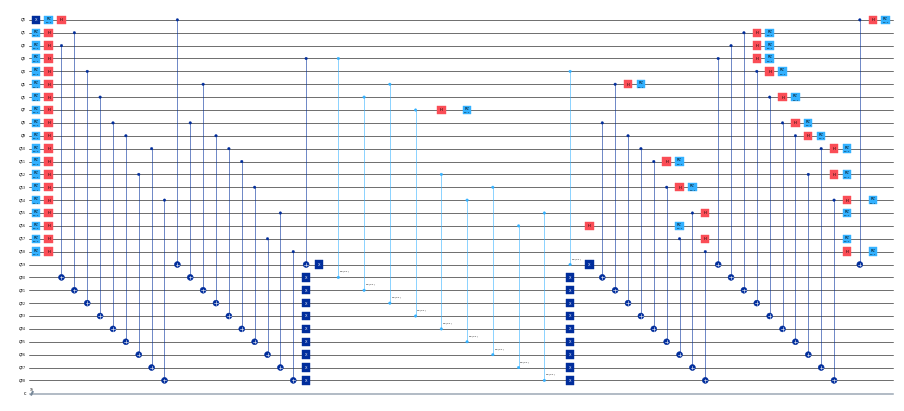

In [6]:
snapshots_rzz = []

circuit = QuantumCircuit(lattice.num_links + lattice.num_plaquettes, lattice.num_links)
circuit.x(0)
for _ in range(10):
    circuit.compose(lattice.electric_evolution(0.5 * delta_t), inplace=True)
    circuit.compose(lattice.magnetic_evolution(K, delta_t, basis_2q='rzz'), inplace=True)
    circuit.compose(lattice.electric_evolution(0.5 * delta_t), inplace=True)
    snapshots_rzz.append(circuit.copy())

snapshots_rzz[0].draw('mpl', scale=0.2, fold=100)

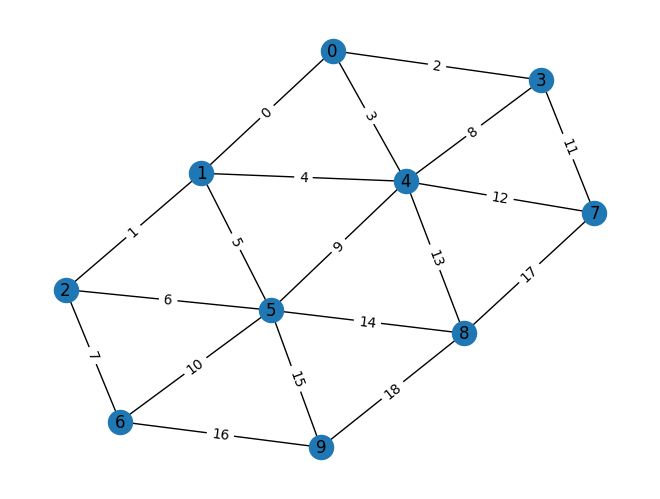

In [7]:
lattice.draw_graph()

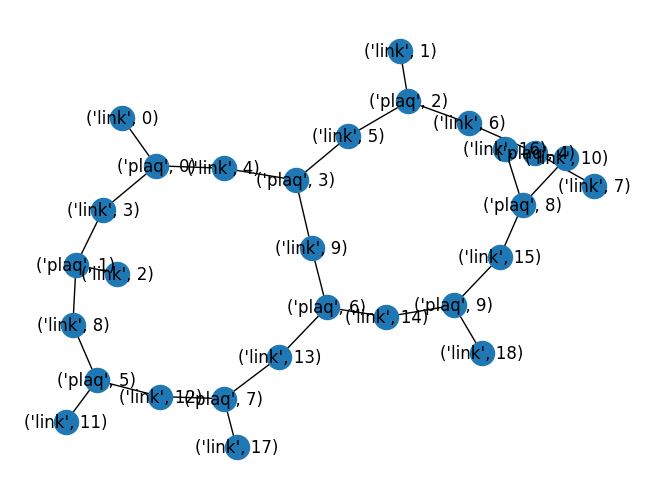

In [8]:
lattice.draw_qubit_graph()

In [9]:
lattice.num_plaquettes

10

## Map to a backend and transpile

In [ ]:
if not use_simulator:
    service = QiskitRuntimeService(channel='ibm_quantum', instance='ibm-q-utokyo/internal/terashi-sr')
    backend = service.backend('ibm_fez')
    backend_frac = service.backend('ibm_fez', use_fractional_gates=True)

In [11]:
if use_simulator:
    circuits = snapshots
else:
    # Generate the physical-qubit layout for the transpiler (map link 0 to qubit 96)
    layout = lattice.layout_heavy_hex(backend.coupling_map, {('link', 0): 96, ('link', 1): 97, ('link', 2): 100})
    circuits_cx = transpile(snapshots_cx, backend=backend, initial_layout=layout)
    circuits = transpile(snapshots_cz + snapshots_rzz, backend=backend_frac, initial_layout=layout)
    circuits_cz = circuits[:10]
    circuits_rzz = circuits[10:]

# Monitoring the plaquette expectation values
observables = [
    SparsePauliOp(
        lattice.to_pauli({lid: 'X' for lid in lattice.plaquette_links(plid)}, pad_to_nq=True)
    ).apply_layout(circuits[0].layout)
    for plid in range(lattice.num_plaquettes)
]

## Exact diagonalization

In [12]:
hamiltonian_op = lattice.make_hamiltonian(K)
observables_links = [
    SparsePauliOp(
        lattice.to_pauli({lid: 'X' for lid in lattice.plaquette_links(plid)})
    )
    for plid in range(lattice.num_plaquettes)
]

# Taking the initial state where link 0 is excited -> Charge subspace is +1 for vertices 0 and 1
subspace = lattice.charge_subspace([1, 1] + [0] * (lattice.num_vertices - 2))

plaquettes = np.array([subspace_projection(obs, subspace) for obs in observables_links])
initial_state = np.zeros_like(subspace, dtype=complex)
initial_state[np.argwhere(subspace == 1)[0]] = 1.

### Full analytic

In [13]:
hamiltonian = jnp.asarray(subspace_projection(hamiltonian_op, subspace))
times = jnp.linspace(delta_t, delta_t * 10., 100)
ev = expm(-1.j * hamiltonian[None, ...] * times[:, None, None])
states = jnp.einsum('tij,j->ti', ev, initial_state)
evs_analytic = jnp.einsum('ti,pij,tj->tp', states.conjugate(), plaquettes, states).real

### Trotter

In [14]:
hamiltonian_m = subspace_projection(SparsePauliOp(hamiltonian_op.paulis[lattice.num_links:], [-K] * lattice.num_plaquettes), subspace)
hamiltonian_e = subspace_projection(SparsePauliOp(hamiltonian_op.paulis[:lattice.num_links], [-1.] * lattice.num_links), subspace)
ev_m = expm(-1.j * hamiltonian_m * delta_t)
ev_e = expm(-0.5j * hamiltonian_e * delta_t)
times_tr = jnp.arange(1, 11) * delta_t
state = initial_state
states_tr = []
for _ in range(10):
    state = ev_e @ ev_m @ ev_e @ state
    states_tr.append(state)
states_tr = jnp.array(states_tr)
evs_tr = jnp.einsum('ti,pij,tj->tp', states_tr.conjugate(), plaquettes, states_tr).real

## Estimator job

In [ ]:
# if use_simulator:
#     estimator = AerEstimator(options={'backend_options': {'device': 'GPU'}})
# else:
#     estimator = Estimator(backend)

# job_cx = estimator.run([(circuit, observables) for circuit in circuits_cx])

with Batch(backend=backend_frac) as batch:
    estimator = Estimator(batch)
    job_cx = estimator.run([(circuit, observables) for circuit in circuits_cx])
    job_cz = estimator.run([(circuit, observables) for circuit in circuits_cz])
    job_rzz = estimator.run([(circuit, observables) for circuit in circuits_rzz])

# marrakesh (rzz failed because angles were negative)
# job_cx = service.job('cz2z7sqp6030008c65m0')
# job_cz = service.job('cz2z85839f40008s46vg')

In [ ]:
#job = service.job('cwmfs34543p00086w8ag')
#job = service.job('cwmfst7543p00086w8f0')

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 [Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.20000000000000004, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5000000000000001, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7')])

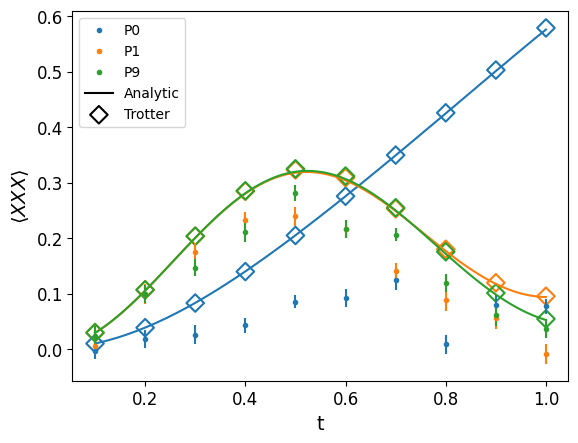

In [ ]:
estimator_result = job_cx.result()

#plotted_plaquettes = list(range(lattice.num_plaquettes))
#plotted_plaquettes = [0, 5, 27]
plotted_plaquettes = [0, 1, 9]

evs = np.array([res.data.evs for res in estimator_result])
stds = np.array([res.data.stds for res in estimator_result])
keys_est = []
marker_tr = MarkerStyle('D', fillstyle='none')
#for ip in range(lattice.num_plaquettes):
for ip in plotted_plaquettes:
    path, _, _ = plt.errorbar(times_tr, evs[:, ip], yerr=stds[:, ip], fmt='.', linestyle='none')
    keys_est.append(path)
    line, = plt.plot(times, evs_analytic[:, ip], color=path.get_color())
    markers = plt.scatter(times_tr, evs_tr[:, ip], s=80., c=path.get_color(), marker=marker_tr)

key_analytic = Line2D([], [])
key_analytic.update_from(line)
key_analytic.set_color('black')
key_tr = PathCollection(markers.get_paths())
key_tr.update_from(markers)
key_tr.set_color('black')
key_tr.set_sizes(markers.get_sizes())
key_tr.set_facecolor('none')
plt.legend(keys_est + [key_analytic, key_tr],
           [f'P{ip}' for ip in plotted_plaquettes] + ['Analytic', 'Trotter'])
plt.xlabel('t', fontsize=14)
plt.ylabel(r'$\langle XXX \rangle$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 [Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.20000000000000004, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5000000000000001, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7')])

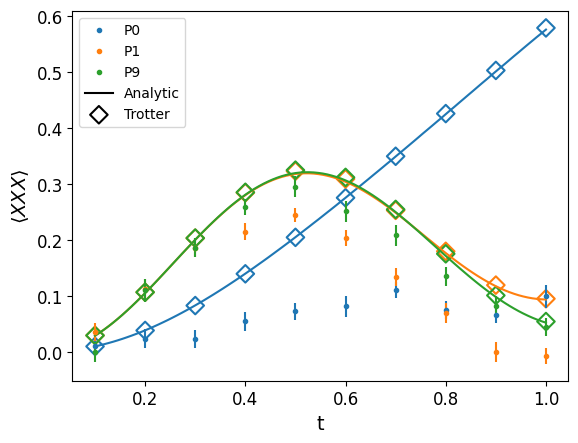

In [ ]:
estimator_result = job_cz.result()

#plotted_plaquettes = list(range(lattice.num_plaquettes))
#plotted_plaquettes = [0, 5, 27]
plotted_plaquettes = [0, 1, 9]

evs = np.array([res.data.evs for res in estimator_result])
stds = np.array([res.data.stds for res in estimator_result])
keys_est = []
marker_tr = MarkerStyle('D', fillstyle='none')
#for ip in range(lattice.num_plaquettes):
for ip in plotted_plaquettes:
    path, _, _ = plt.errorbar(times_tr, evs[:, ip], yerr=stds[:, ip], fmt='.', linestyle='none')
    keys_est.append(path)
    line, = plt.plot(times, evs_analytic[:, ip], color=path.get_color())
    markers = plt.scatter(times_tr, evs_tr[:, ip], s=80., c=path.get_color(), marker=marker_tr)

key_analytic = Line2D([], [])
key_analytic.update_from(line)
key_analytic.set_color('black')
key_tr = PathCollection(markers.get_paths())
key_tr.update_from(markers)
key_tr.set_color('black')
key_tr.set_sizes(markers.get_sizes())
key_tr.set_facecolor('none')
plt.legend(keys_est + [key_analytic, key_tr],
           [f'P{ip}' for ip in plotted_plaquettes] + ['Analytic', 'Trotter'])
plt.xlabel('t', fontsize=14)
plt.ylabel(r'$\langle XXX \rangle$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [26]:
from qiskit.quantum_info import Operator
c = QuantumCircuit(2)
c.x(1)
c.rzz(-0.3, 0, 1)
c.x(1)
np.diagonal(Operator(c).data)

array([0.98877108-0.14943813j, 0.98877108+0.14943813j,
       0.98877108+0.14943813j, 0.98877108-0.14943813j])

In [25]:
c = QuantumCircuit(2)
c.rzz(-0.3, 0, 1)
np.diagonal(Operator(c).data)

array([0.98877108+0.14943813j, 0.98877108-0.14943813j,
       0.98877108-0.14943813j, 0.98877108+0.14943813j])